In [1]:
%matplotlib inline
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
import pandas as pd # import pandas library as pd 
from numpy import fft
from datetime import datetime
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':16,'axes.labelsize':20,'axes.titlesize':20,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)

In [2]:
# Logarithmic return of price time series
def logreturn(St,tau=1):
    return np.log(St[tau:])-np.log(St[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
# normalize data to have zero mean (<x> = 0) and unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return ((data-np.average(data))/np.sqrt(np.var(data)))
# compute self-correlation of vector v
def auto_correlate(v):
    # np.correlate computes C_{v}[k] = sum_n v[n+k] * v[n]
    corr = np.correlate(v,v,mode="full") # correlate returns even array [0:2*nums-1] centered at nums-1
    return corr[len(v)-1:]/len(v) # take positive values and normalize by number of points

In [3]:
def model2(params,p0,numt):
    def avgprice(dpn): # compute running average Eq.(L6)
        M = len(dpn)    # 
        weights  = np.array(range(1,M+1))*2.0/(M*(M+1))
        return weights.dot(dpn)
    
    mktprice = np.zeros(numt)   # initialize market price P(n)
    dmktprice= np.zeros(numt)   # initialize change in price dP(n) needed for running average
    ticktime = np.zeros(numt,dtype=np.int) #initialize array for tick times
    price    = np.array([p0[0], p0[1]])    #initialize dealer's mid-price (p1,p2)
    time,tick= 0,0 # real time(t) and time time (n)
    deltapm  = 0.0 # trend term d <dP>_m dt for current random walk
    cdp      = params['c']*params['dp'] # define random step size
    ddt      = params['d']*params['dt'] # define amplitude of trend term
    while tick < numt: # loop over ticks
        while np.abs(price[0]-price[1]) < params['L']: # transaction criterion Eq.(L1)
            price = price + deltapm + np.random.choice([-cdp,cdp], size=2) # random walk step Eq.(L4)
            time += 1 #update real time
        price[:]       = np.average(price) #set mid-prices to new market price Eq.(L2)
        mktprice[tick] = price[0]  # save market price
        dmktprice[tick]= mktprice[tick] - mktprice[np.max([0,tick-1])] # save dP(n) = P(n) - P(n-1)
        ticktime[tick] = time # save transaction time
        tick += 1 #update ticks
        tick0 = np.max([0, tick - params['M']]) #compute tick start for running average
        deltapm = avgprice(dmktprice[tick0:tick])*ddt #compute updated trend term for current tick time
    return ticktime,mktprice

In [5]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.25, 'M':1} # define model parameters
def model2RW(params,p0,deltapm):        # simulate Random-Walk for 1 transaction
    price = np.array([p0[0], p0[1]])    # initialize mid-prices for dealers p_1 and p_2
    cdp   = params['c']*params['dp']    # define random step size
    ddt   = params['d']*params['dt']    # define trend drift term
    Dt    = [price[0]-price[1]]         # initialize price difference as empty list
    At    = [np.average(price)]         # initialize avg price as empy list
    while np.abs(price[0]-price[1]) < params['L']:
        price=price+np.random.choice([-cdp,cdp],size=2) # random walk step for mid-prices Eq. (L4)
        price=price+ddt*deltapm         # Model 2 : add trend-following term in Eq. (L4)
        Dt.append(price[0]-price[1])
        At.append(np.average(price))
    return np.array(Dt),np.array(At)-At[0] # return difference array and average centered at zero

d-2.0 : number of steps =  12826 , price change =  -0.0025950000897552172
d-1.25 : number of steps =  12826 , price change =  0.00029062501231180704
d0.0 : number of steps =  12826 , price change =  0.0051000000001693024
d+1.25 : number of steps =  12826 , price change =  0.009909374988026798
d+2.0 : number of steps =  12826 , price change =  0.012795000090093822


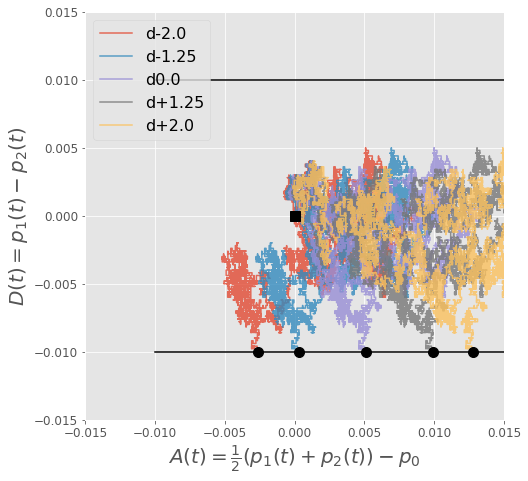

In [13]:
fig,ax=plt.subplots(figsize=(7.5,7.5),subplot_kw={'xlabel':r'$A(t) = \frac{1}{2}\left(p_1(t) + p_2(t)\right) - p_0$', 'ylabel':r'$D(t) = p_1(t) - p_2(t)$'})
p0 = [100.25, 100.25]
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.25, 'M':10} # define model parameters
for d,lbl in zip([-2.0, -1.25, 0.0, 1.25, 2.0], ['d-2.0', 'd-1.25', 'd-0.0', 'd+1.25', 'd+2.0']):
    np.random.seed(0)
    params['d'] = d
    Dt,At = model2RW(params, p0, 0.003)
    ax.plot(At,Dt,alpha=0.8,label=lbl) #plot random walk trajectory
    ax.plot(At[-1],Dt[-1],marker='o',color='k', markersize=10) #last point
    print(lbl+' : number of steps = ',len(At),', price change = ', At[-1])
ax.plot(0, 0, marker='s', color='k', markersize=10) # starting position
ax.plot([-0.01,0.03],[params['L'],params['L']],color='k') #top absorbing boundary P=L
ax.plot([-0.01,0.03],[-params['L'],-params['L']],color='k') #bottom absorbing boundary P=-L
ax.legend(loc='upper left')
ax.set_ylim([-0.015, 0.015])
ax.set_xlim([-0.015, 0.015])
plt.show()

In [4]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.00, 'M':10} # define model parameters
price = np.zeros((5,5000))
# run 5 simulations with different d paramaters
for i,d,lbl in zip(range(5),[-2.0, -1.25, 0.0, 1.25, 2.0], ['d-2.0', 'd-1.25', 'd0.0', 'd+1.25', 'd+2.0']):
    np.random.seed(0)
    params['d'] = d
    print(params['d'])
    time,price[i] = model2(params, [100.25, 100.25], 5000)
np.savetxt('model2_M10_5d.txt', np.transpose(price), header="d-2\t d-1\t d0\t d+1\t d+2", comments=' ')

-2.0


/home/xiaoqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


-1.25
0.0
1.25
2.0


In [14]:
price  = pd.read_csv('model2_M10_5d.txt', header=0, delim_whitespace=True, index_col=False)
dprice = pd.DataFrame()
for lbl in price.columns:
    dprice[lbl] = normalized(logreturn(price[lbl].values, 1)) #price return G_1
dprice.head()

,d-2,d-1,d0,d+1,d+2
0,0.064483,0.064803,0.062363,0.042186,-0.093576
1,-0.249174,-0.245864,-0.235129,-0.193000,-0.100403
2,-0.759109,-0.824618,-0.909471,-0.824092,-0.120481
3,2.264443,1.994706,1.411017,0.612311,-0.087087
4,-0.453285,-0.333167,-0.215293,-0.201743,-0.102947


/home/xiaoqi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/xiaoqi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


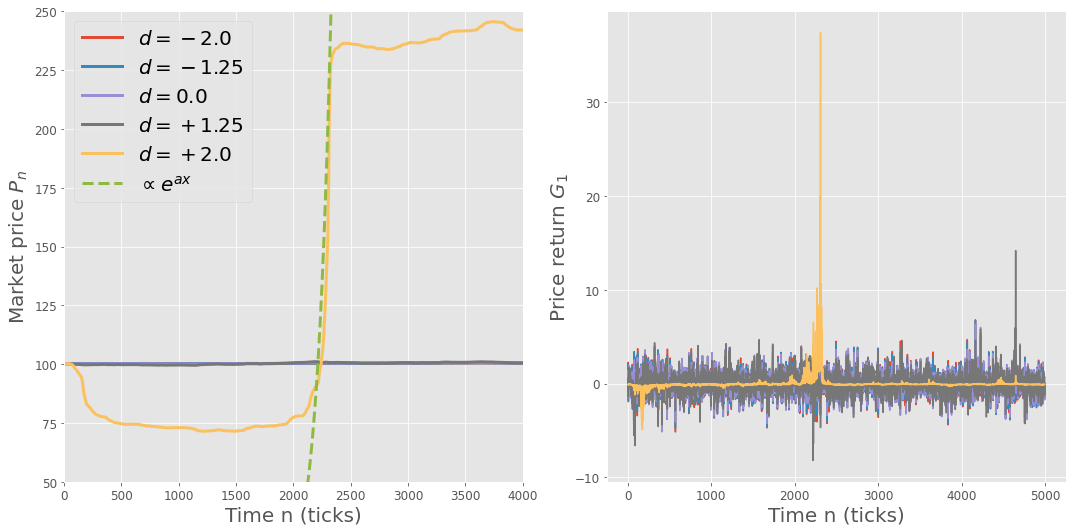

In [15]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'xlabel':r'Time n (ticks)'})
price.plot(ax=ax, lw=3)
dprice.plot(ax=bx, legend=False)
x = np.arange(1000,2550)
ax.plot(x,0.03*np.exp(8e-3*(x-1200)),lw=3,ls='--',label='exponential')
ax.set_ylim(50,250)
ax.set_xlim(0,4000)
ax.legend([r'$d=-2.0$', r'$d=-1.25$', r'$d=0.0$', r'$d=+1.25$', r'$d=+2.0$', r'$\propto e^{a x}$'], loc=2, fontsize=20)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price return $G_{1}$')
fig.tight_layout() # get nice spacing between plots
plt.show()

/home/xiaoqi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/xiaoqi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


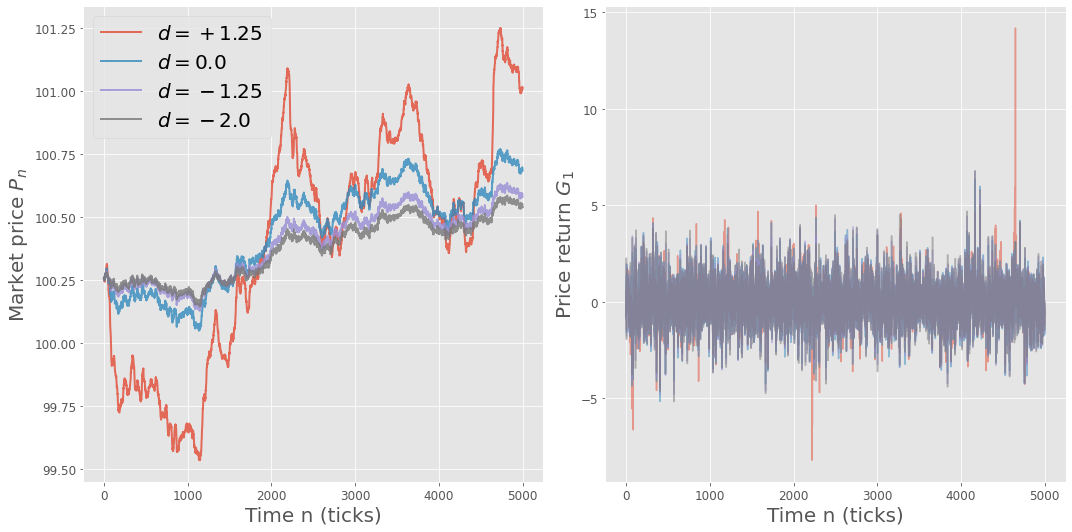

In [18]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'xlabel':r'Time n (ticks)'})
cols = ['d+1','d0','d-1','d-2']
price[cols].plot(ax=ax, lw=2, alpha=0.8)
dprice[cols].plot(ax=bx, alpha=0.5, legend=False)
ax.legend([r'$d=+1.25$', r'$d=0.0$', r'$d=-1.25$', r'$d=-2.0$'], loc=2, fontsize=20)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price return $G_{1}$')
fig.tight_layout() # get nice spacing between plots
plt.show()

## Compare with real market data

In [22]:
from datetime import datetime, timedelta
import pandas_datareader as pdr

In [23]:
# define time interval
end_time   = datetime.today() - timedelta(days=5)
start_time = datetime(end_time.year - 10, end_time.month, end_time.day)
sp500      = pdr.DataReader('^GSPC','yahoo',start_time,end_time)
sp500 = sp500.reset_index(level=0)
sp500

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-09-27,1450.199951,1433.359985,1433.359985,1447.150024,3150330000,1447.150024
1,2012-09-28,1447.130005,1435.599976,1447.130005,1440.670044,3509230000,1440.670044
2,2012-10-01,1457.140015,1440.900024,1440.900024,1444.489990,3505080000,1444.489990
3,2012-10-02,1451.520020,1439.010010,1444.989990,1445.750000,3321790000,1445.750000
4,2012-10-03,1454.300049,1441.989990,1446.050049,1450.989990,3531640000,1450.989990
...,...,...,...,...,...,...,...
2511,2022-09-21,3907.070068,3789.489990,3871.399902,3789.929932,4078330000,3789.929932
2512,2022-09-22,3790.899902,3749.449951,3782.360107,3757.989990,4284600000,3757.989990
2513,2022-09-23,3727.139893,3647.469971,3727.139893,3693.229980,5144270000,3693.229980
2514,2022-09-26,3715.669922,3644.760010,3682.719971,3655.040039,4886140000,3655.040039


In [24]:
# Logarithmic return of price time series
def logreturn(Pt,tau=1):
    return np.log(Pt[tau:]) - np.log(Pt[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
# normalize data to have unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return (data/np.sqrt(np.var(data)))
# compute normalized probability distribution function
def pdf(data,bins=50):
    hist, edges = np.histogram(data[~np.isnan(data)], bins=bins, density=True) # remove NaNs and compute histogram (returns bar heights and bar edges)
    edges   = (edges[:-1] + edges[1:])/2.0 # get bar centers
    nonzero = hist > 0.0                   # only keep non-zero points 
    return edges[nonzero], hist[nonzero]
def computeReturn(data, name, tau):
    data[name]=pd.Series(normalized(logreturn(data['Close'].values, tau)),index=data.index[:-tau])

In [25]:
computeReturn(sp500, 'Return d1', 1)

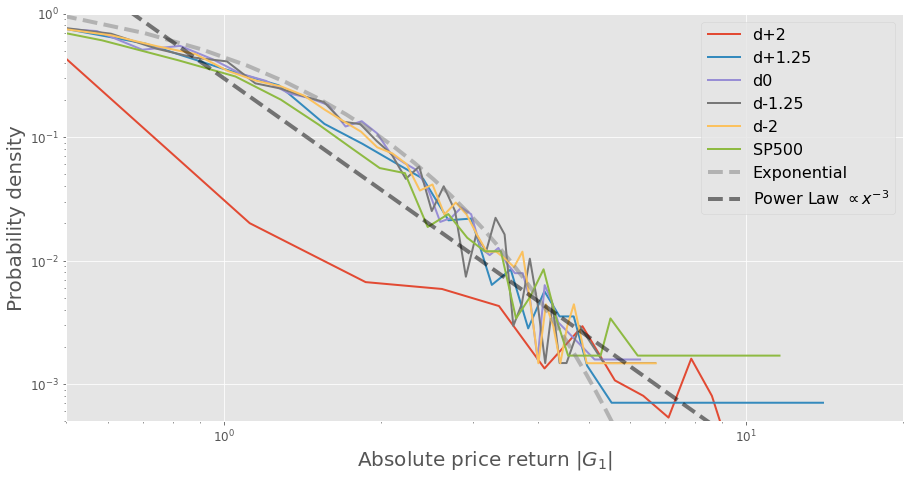

In [28]:
fig,ax,=plt.subplots(figsize=(15,7.5),subplot_kw={'xlabel':r'Absolute price return $|G_1|$', 'ylabel':r'Probability density'})
for data,lbl in zip([dprice['d+2'], dprice['d+1'], dprice['d0'], dprice['d-1'], dprice['d-2'], sp500['Return d1']], ['d+2','d+1.25', 'd0', 'd-1.25', 'd-2', 'SP500']):
    edges, hist = pdf(np.abs(data), bins=50)
    ax.plot(edges, hist, label=lbl, lw=2)
x = np.linspace(0.1, 10)
ax.plot(x, 2*np.exp(-1.5*x),lw=4,color='gray',ls='--',alpha=0.5,label=r'Exponential')
ax.plot(x, 0.3*x**(-3), lw=4, color='k', ls='--', alpha=0.5, label=r'Power Law $\propto x^{-3}$')
ax.set_xlim(5e-1, 2e1)
ax.set_ylim(5e-4, 1)
ax.legend()
ax.semilogx()
ax.semilogy()
plt.show()